# Evaluation of ResNet models

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import numpy as np
from tqdm import tqdm
from PIL import Image
from IPython.display import display
import os
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.utils as vutils
import torch.nn.functional as F

In [2]:
eval_experiment = "bw_wo_interpolation"
eval_filepath = "img2lut_bw_wo_interpolation.pth.tar"
learning_rate = 0.001
batch_size=64

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = x
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(residual)
        return F.relu(out)

In [5]:
class ResNetLUTGenerator(nn.Module):
    def __init__(self, lut_size=8, trilinear=True, input_channels=3):
        super(ResNetLUTGenerator, self).__init__()
        self.lut_size = lut_size
        self.trilinear = trilinear
        
        # Initial convolution
        self.initial_conv = nn.Sequential(
            nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU()
        )
        
        # ResNet feature extraction
        self.layer1 = self._make_layer(32, 64, stride=2)
        self.layer2 = self._make_layer(64, 128, stride=2)
        self.layer3 = self._make_layer(128, 256, stride=2)
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        
        # LUT generator
        self.lut_generator = nn.Sequential(
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, lut_size * lut_size * lut_size * 3)
        )

    def _make_layer(self, in_channels, out_channels, stride):
        return ResidualBlock(in_channels, out_channels, stride)


    def _trilinear_interpolation(self, luts, images):
        # Ensure LUT is reshaped properly (N, size, size, size, 3)
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        
        # Normalize image to range [0, lut_size - 1]
        lut_size = luts.shape[2]
        image_normalized = (images * (lut_size - 1))
        image_normalized = torch.clamp(image_normalized, 0, lut_size - 1)
    
        # Get the integer floor and ceil indices for each channel
        r_floor = image_normalized[:, 0, :, :].floor().long()
        g_floor = image_normalized[:, 1, :, :].floor().long()
        b_floor = image_normalized[:, 2, :, :].floor().long()
    
        r_ceil = torch.clamp(r_floor + 1, 0, lut_size - 1)
        g_ceil = torch.clamp(g_floor + 1, 0, lut_size - 1)
        b_ceil = torch.clamp(b_floor + 1, 0, lut_size - 1)
    
        # Calculate interpolation weights
        r_weight = image_normalized[:, 0, :, :] - r_floor.float()
        g_weight = image_normalized[:, 1, :, :] - g_floor.float()
        b_weight = image_normalized[:, 2, :, :] - b_floor.float()
    
        # Helper function to gather LUT values
        def gather_lut(lut, r, g, b):
            return lut[torch.arange(lut.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
    
        # Perform trilinear interpolation (8 corners of the cube)
        c000 = gather_lut(lut, r_floor, g_floor, b_floor)
        c001 = gather_lut(lut, r_floor, g_floor, b_ceil)
        c010 = gather_lut(lut, r_floor, g_ceil, b_floor)
        c011 = gather_lut(lut, r_floor, g_ceil, b_ceil)
        c100 = gather_lut(lut, r_ceil, g_floor, b_floor)
        c101 = gather_lut(lut, r_ceil, g_floor, b_ceil)
        c110 = gather_lut(lut, r_ceil, g_ceil, b_floor)
        c111 = gather_lut(lut, r_ceil, g_ceil, b_ceil)
    
        # Interpolate along the R axis
        c00 = c000 * (1 - r_weight).unsqueeze(-1) + c100 * r_weight.unsqueeze(-1)
        c01 = c001 * (1 - r_weight).unsqueeze(-1) + c101 * r_weight.unsqueeze(-1)
        c10 = c010 * (1 - r_weight).unsqueeze(-1) + c110 * r_weight.unsqueeze(-1)
        c11 = c011 * (1 - r_weight).unsqueeze(-1) + c111 * r_weight.unsqueeze(-1)
    
        # Interpolate along the G axis
        c0 = c00 * (1 - g_weight).unsqueeze(-1) + c10 * g_weight.unsqueeze(-1)
        c1 = c01 * (1 - g_weight).unsqueeze(-1) + c11 * g_weight.unsqueeze(-1)
    
        # Interpolate along the B axis
        transformed = c0 * (1 - b_weight).unsqueeze(-1) + c1 * b_weight.unsqueeze(-1)
    
        # Permute to (N, C, H, W) format
        transformed = transformed.permute(0, 3, 1, 2)
    
        return transformed

    def _simple_approach(self, luts, images):
        lut = luts.view(luts.shape[0], luts.shape[2], luts.shape[2], luts.shape[2], 3)
        image_normalized = (images * luts.shape[2]-1).long()
        image_normalized = torch.clamp(image_normalized, 0, luts.shape[2]-1)
            
        r = image_normalized[:, 0, :, :]
        g = image_normalized[:, 1, :, :]
        b = image_normalized[:, 2, :, :]
            
        transformed = lut[torch.arange(luts.shape[0]).unsqueeze(-1).unsqueeze(-1), r, g, b]
        transformed = transformed.permute(0, 3, 1, 2)

        return transformed


    def forward(self, x):
        # Feature extraction
        x_orig = x  # Store original input
        x = self.initial_conv(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        
        # Global pooling and feature compression
        features = self.global_pool(x).view(x.size(0), -1)
        
        # Generate LUT
        lut = self.lut_generator(features)
        lut = lut.view(-1, self.lut_size, self.lut_size, self.lut_size, 3)
        lut = torch.sigmoid(lut)
        
        # Apply LUT to original input
        if self.trilinear:
            transformed = self._trilinear_interpolation(lut, x_orig)
        else:
            transformed = self._simple_approach(lut, x_orig)
        return transformed, lut

### Load model

In [29]:
eval_model = ResNetLUTGenerator(lut_size=33, trilinear=False).to(device)
eval_optimizer = optim.Adam(eval_model.parameters(), lr=learning_rate)

In [30]:
def load_checkpoint(model, optimizer, experiment, filepath):
    
    filepath = f"models/{experiment}/{filepath}"
    print(f"=> Loading checkpoint from {filepath}")
    checkpoint = torch.load(filepath, weights_only=True)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    return model, optimizer

In [31]:
eval_generator, _ = load_checkpoint(eval_model, eval_optimizer, eval_experiment, eval_filepath)

=> Loading checkpoint from models/bw_wo_interpolation/img2lut_bw_wo_interpolation.pth.tar


### Load model that was trained with interpolation as comparison

In [32]:
eval_experiment2 = "bw_w_interpolation"
eval_filepath2 = "img2lut_bw_w_interpolation.pth.tar"
eval_model2 = ResNetLUTGenerator(lut_size=33, trilinear=True).to(device)
eval_optimizer2 = optim.Adam(eval_model2.parameters(), lr=learning_rate)
eval_generator_interpol, _ = load_checkpoint(eval_model2, eval_optimizer2, eval_experiment2, eval_filepath2)

=> Loading checkpoint from models/bw_w_interpolation/img2lut_bw_w_interpolation.pth.tar


In [33]:
class PairedImageDataset(Dataset):
    def __init__(self, ungraded_images, graded_images, transform=None):
        self.ungraded_images = ungraded_images
        self.graded_images = graded_images
        self.transform = transform

    def __len__(self):
        return len(self.ungraded_images)

    def __getitem__(self, idx):
        # Returns an ungraded and a graded image
        ungraded = self.ungraded_images[idx]
        graded = self.graded_images[idx]
        if self.transform:
            ungraded = self.transform(ungraded)
            graded = self.transform(graded)
        return ungraded, graded

In [34]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

In [35]:
transform64 = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
])

## Is the generated LUT always the same?

In [36]:
luts = []
for i in range(5):
    sample_input = torch.rand(1, 3, 64, 64).to(device)
    _, lut = eval_model(sample_input)
    luts.append(lut)

In [37]:
total_difference = sum(torch.sum(torch.abs(luts[i] - luts[j])) for i in range(len(luts)) for j in range(i + 1, len(luts)))

print(f"Total sum of differences: {total_difference}")

Total sum of differences: 3162.09423828125


The generated LUT appears to be image adaptive / not always the same.

## Performance on test images (Kodak Ektar not Ultramax)

In [38]:
def load_images_from_directory(directory_path, num_images=100, apply_transform=True):
    images = []
    files = os.listdir(directory_path)
    # Ensure only images are processed
    image_files = [f for f in files if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    for i, image_file in enumerate(image_files[:num_images]):
        image_path = os.path.join(directory_path, image_file)
        img = Image.open(image_path).convert('RGB')  # Convert to RGB in case of grayscale
        if apply_transform:
            img = transform64(img)  # Apply the transformations

        else:
            img = transform(img)
        images.append(img)
        
    images_tensor = torch.stack(images)
    images_tensor = images_tensor.permute(0, 2, 3, 1)
    return images_tensor

ungraded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ektar', num_images=400)
graded_images = load_images_from_directory('../../analogdb_images_scaled/kodak_ektar/BW', num_images=400)

# Verify the shape of the tensors
print(ungraded_images.shape)  
print(graded_images.shape)

torch.Size([400, 256, 256, 3])
torch.Size([400, 256, 256, 3])


In [39]:
ungraded_images_np = ungraded_images.numpy()
graded_images_np = graded_images.numpy()

dataset = PairedImageDataset(ungraded_images_np, graded_images_np, transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [40]:
ungraded, graded = next(iter(dataloader))

In [41]:
ungraded = ungraded.to(device)
edited_images, luts = eval_generator(ungraded)
edited_images_interpol, luts = eval_generator_interpol(ungraded)

In [42]:
def calc_mse(images1, images2):
    mse = torch.mean((images1 - images2) ** 2)
    return mse

In [43]:
mse = calc_mse(graded.to(device),edited_images)
mse_interpol = calc_mse(graded.to(device),edited_images_interpol)

In [44]:
print(mse)
print(mse_interpol)

tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<MeanBackward0>)


In [49]:
print(f"Difference between MSE:{mse-mse_interpol}")

Difference between MSE:0.0001607966551091522


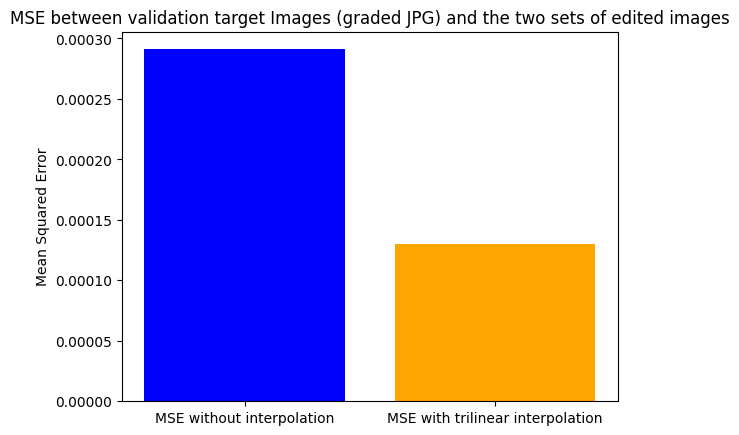

In [50]:
labels = ['MSE without interpolation', 'MSE with trilinear interpolation']
values = [mse.cpu().item(), mse_interpol.cpu().item()]

plt.bar(labels, values, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Mean Squared Error')
plt.title('MSE between validation target Images (graded JPG) and the two sets of edited images')

plt.show()

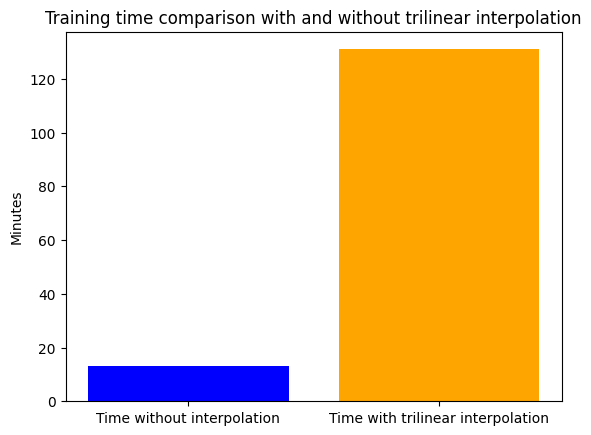

In [48]:
labels = ['Time without interpolation', 'Time with trilinear interpolation']
values = [13, 131]

plt.bar(labels, values, color=['blue', 'orange'])

# Add labels and title
plt.ylabel('Minutes')
plt.title('Training time comparison with and without trilinear interpolation')

plt.show()

In [23]:
def display_image(image, width=256):
    tensor_image = image.detach().cpu()
    # Rearrange to HWC format and scale to [0, 255]
    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    display(image)

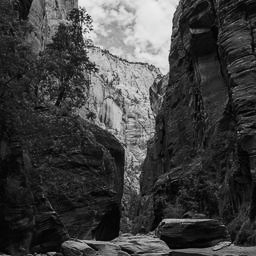

In [24]:
display_image(edited_images[0])

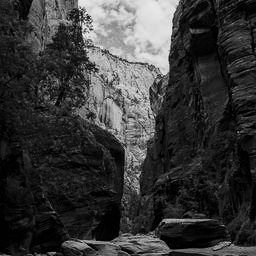

In [28]:
display_image(edited_images_interpol[0])

## Test of the application of a LUT to an image

In [25]:
def apply_lut_to_image_interpolation(image, lut, lut_size):
    """
    Applies the LUT to the image using trilinear interpolation for better quality.
    
    Args:
        image: PIL Image in RGB format
        lut: 3D LUT array of shape (lut_size, lut_size, lut_size, 3)
        lut_size: Size of the LUT cube
    """
    tensor_image = image.detach().cpu()

    image_np = np.transpose(tensor_image.numpy(), (1, 2, 0))  # Select the first image in batch and permute to HWC
    image_np = (image_np * 255).clip(0, 255).astype(np.uint8)
            
    image = Image.fromarray(image_np)
    
    # Convert image to RGB numpy array
    image = image.convert("RGB")
    image_data = np.array(image).astype(np.float32) / 255.0
    
    # Scale factors for the LUT
    scale = (lut_size - 1)
    scaled_data = image_data * scale
    
    # Get the floor and ceil indices for interpolation
    floor_idx = np.floor(scaled_data).astype(int)
    ceil_idx = np.minimum(floor_idx + 1, lut_size - 1)
    
    # Calculate interpolation weights
    alpha = scaled_data - floor_idx
    
    # Get the 8 neighboring points in the LUT
    c000 = lut[floor_idx[..., 0], floor_idx[..., 1], floor_idx[..., 2]]
    c001 = lut[floor_idx[..., 0], floor_idx[..., 1], ceil_idx[..., 2]]
    c010 = lut[floor_idx[..., 0], ceil_idx[..., 1], floor_idx[..., 2]]
    c011 = lut[floor_idx[..., 0], ceil_idx[..., 1], ceil_idx[..., 2]]
    c100 = lut[ceil_idx[..., 0], floor_idx[..., 1], floor_idx[..., 2]]
    c101 = lut[ceil_idx[..., 0], floor_idx[..., 1], ceil_idx[..., 2]]
    c110 = lut[ceil_idx[..., 0], ceil_idx[..., 1], floor_idx[..., 2]]
    c111 = lut[ceil_idx[..., 0], ceil_idx[..., 1], ceil_idx[..., 2]]

    # Perform trilinear interpolation
    c00 = c000 * (1 - alpha[..., 2:]) + c001 * alpha[..., 2:]
    c01 = c010 * (1 - alpha[..., 2:]) + c011 * alpha[..., 2:]
    c10 = c100 * (1 - alpha[..., 2:]) + c101 * alpha[..., 2:]
    c11 = c110 * (1 - alpha[..., 2:]) + c111 * alpha[..., 2:]
    
    c0 = c00 * (1 - alpha[..., 1:2]) + c01 * alpha[..., 1:2]
    c1 = c10 * (1 - alpha[..., 1:2]) + c11 * alpha[..., 1:2]
    
    interpolated = c0 * (1 - alpha[..., 0:1]) + c1 * alpha[..., 0:1]
    
    # Convert back to uint8 with proper rounding
    output = np.clip(interpolated * 255.0, 0, 255)
    output = np.round(output).astype(np.uint8)
    
    return Image.fromarray(output)

In [26]:
interpolated_image = apply_lut_to_image_interpolation(ungraded[0].cpu(), luts[0].detach().cpu().numpy(), lut_size=33)

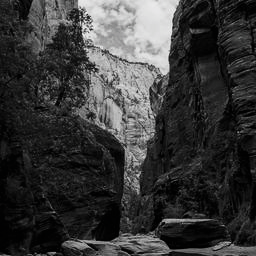

In [27]:
display(interpolated_image)